# Färjerederiet M/S Fröja

### Initial setup

In [1]:
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import sys
sys.path.append("../../")
from vessel_model_tuning_lib import ship_dimensions, maneuvering, resistance, seakeeping, vessel_model_common, actuators

plt.style.use('bmh')

## Vessel data input section
For transparency, all input data used to create the vessel model should be stated in this section. All data used to override default values should also be defined here.

In [2]:
'''
Required data
'''
ship_name = 'Froja'
Lpp = 54 # Length between the perpendiculars
B = 11.7 # Beam in the water line
T = 0.8 # Draft
volume_displacement = 250

'''
Additional known data used in the modelling
'''
Loa = 63 #Length over all (used in quay collision model)
Boa = 13.7 #Beam over all (used in quay collision model)
water_density = 1000.0 # Froja operates in freshwater

#Thruster data
max_rpm = 1750
min_rpm = -max_rpm
bollard_pull_rpm = [1400, 1600, 1750]
bollard_pull_force = np.array([3.4, 4.3, 5.5]) #Bollard pull force for both thrusters in tons

#Resistance data (Ferjerederiet provided datapoints on rpm vs. speed)
resistance_data_speed_knots = np.array([6.8, 7.5, 9.2])
resistance_data_rpm = [1200, 1300, 1750]
max_speed_knots = 9.2

'''
Data estimated from tuning or model fitting
'''
propeller_geometry = actuators.PropellerGeometry.WAGENINGEN_B3_65_PD1 #Selected based on best fit with bollard pull thrust data from Ferjerederiet
propeller_diameter = 0.52 #Tuned to make bollard pull thrust curve match data from Ferjerederiet
CD_lateral = 0.045 #Extra resistance due to viscous effects (such as submerged transom stern). Tuned to fit resistance data from Ferjerederiet)
GM_roll = 10.0 # Roll metacentric height. Tuned to get reasonable natural period of oscillation in seakeeping model
GM_pitch = 80.0 # pitch metacentric height. Tuned to get reasonable natural period of oscillation in seakeeping model
damping_ratio_heave = 0.3 #Tunable parameter to get desired damping in the seakeeping decay response
damping_ratio_roll = 0.15 #Tunable parameter to get desired damping in the seakeeping decay response
damping_ratio_pitch = 0.3 #Tunable parameter to get desired damping in the seakeeping decay response

### Define the physical constants to be used in the modelling

In [3]:
physical_constants = vessel_model_common.physical_constants()
physical_constants.rho = 1000.0 # Override default, which is saltwater density

### Generate ship coefficients based on given main dimension using empirical formulat
If any coefficients are known, they can be overridden in the generated `ship_dimensions` object

In [4]:
ship_dim = ship_dimensions.ShipDimensions(Lpp, B, T, volume_displacement)
ship_dim.print()

Wetted surface:    438.5 m^2
Longitudonal center of gravity:    0.0 m
Longitudonal center of buoyancy:    0.0 m
Block coefficient: 0.4946
Prismatic coefficient: 0.7125
Mid section coefficient: 0.95
Water plane coefficient: 0.75


## Propeller tuning

Thrust at data points: [10189.33244812 11881.57310901 22166.14574091]


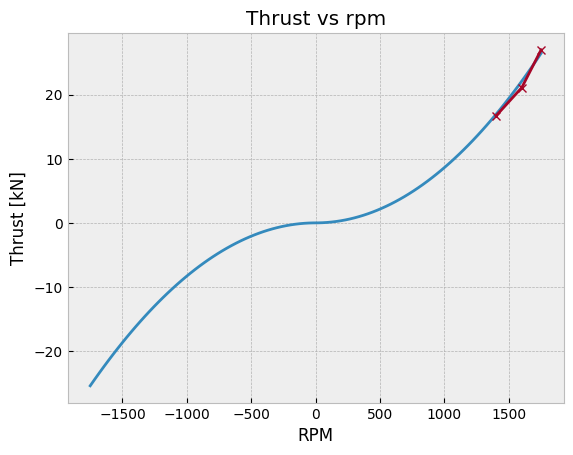

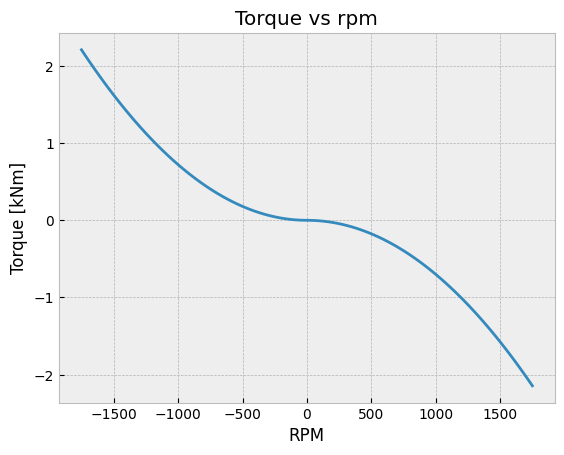

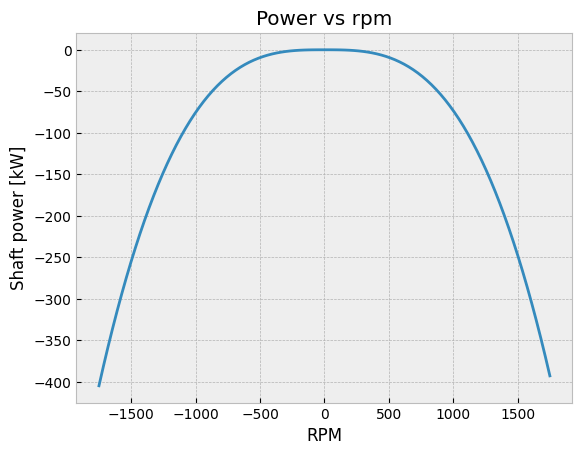

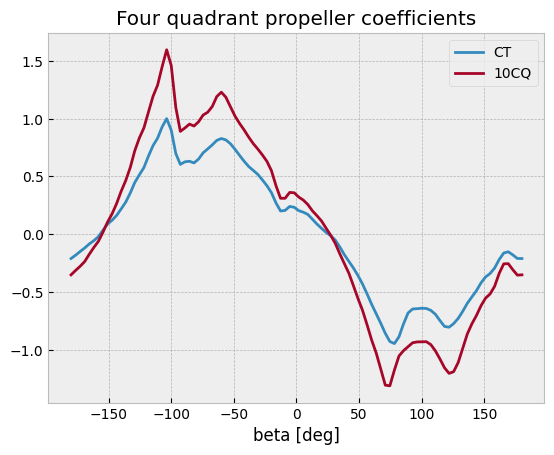

In [5]:
prop = actuators.FourQuadrantPropeller(propeller_geometry, propeller_diameter)

#Plot bollard pull thrust
speed = 0.0
rpm_list = np.linspace(min_rpm, max_rpm, 100)
thrust_ax, torque_ax, power_ax = prop.plot_thrust_torque_power_vs_rpm(rpm_list, speed)
bollard_pull_force_per_thruster = physical_constants.g * bollard_pull_force / 2 #Divide by 2 to get force per thruster, convert from tons to kN
thrust_ax.plot(bollard_pull_rpm, bollard_pull_force_per_thruster, marker='x')

#Get thrust at rpm/speed data points from Färjerederiet. These are used to fit vessel resistance later
resistance_data_speed_ms = resistance_data_speed_knots * vessel_model_common.knots_to_ms
resistance_data_thrust = np.zeros(len(resistance_data_speed_ms))
for i in range(len(resistance_data_thrust)):
    resistance_data_thrust[i] = prop.get_thrust(resistance_data_speed_ms[i], resistance_data_rpm[i])
print(f'Thrust at data points: {resistance_data_thrust}')

#Plot four quadrant curves for propeller geometry
prop.four_quadrant_plot()
plt.show()


## Straight ahead resistance

### Estimate paramaters for straight ahead resistance

Shape factor, k =  0.0256


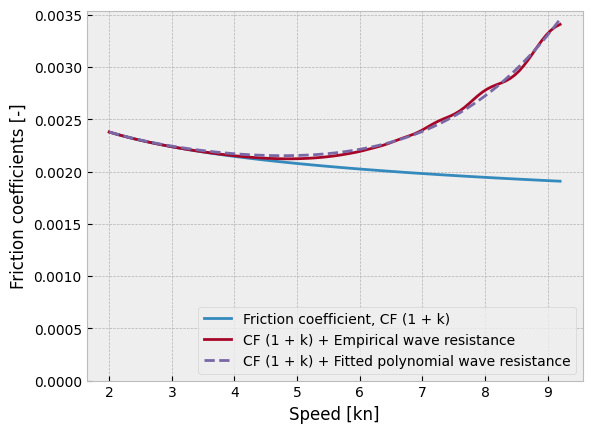

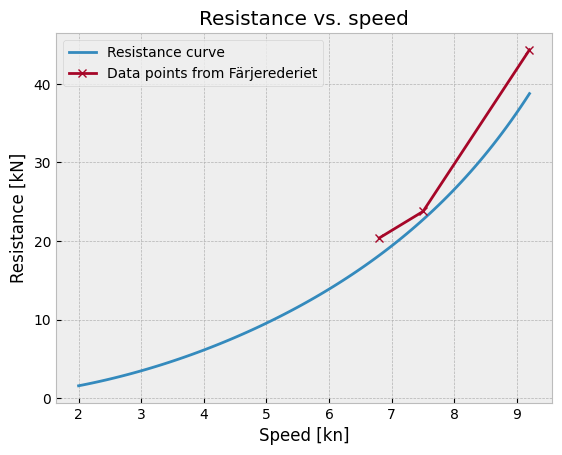

In [6]:
n = 100
U_res_knots = np.linspace(2, max_speed_knots, n)
U_res = U_res_knots * vessel_model_common.knots_to_ms

Fr = U_res / np.sqrt(ship_dim.L * physical_constants.g) #Froude number

k = resistance.marintek_shape_factor(ship_dim) #Empirical shape factor based on MARINTEK formula

print('Shape factor, k = ', np.round(k, 4))


CR = np.zeros(n)
CF = np.zeros(n)
for i in range(n):
    CR[i] = resistance.holtrop_wave_resistance(ship_dim, U_res[i], physical_constants.g, physical_constants.rho) # Resistance coeff due to wave generation (empirical based on Holtrop's method)
    CF[i] = resistance.CF_ITTC(ship_dim, U_res[i], physical_constants.nu) * (1 + k) # Resistance coeff due to friction (empirical based on ITTC friction line)
CT = CF + CR
    
CR_m, CR_p = resistance.fit_wave_polynomial(Fr, CR) # Fit resistance model to polynomial model to be used in the FMU
CR_model = resistance.CR_wave_polynomial(Fr, CR_m, CR_p)

#Plot resistance coefficients
plt.figure()
plt.plot(U_res_knots, CF, label='Friction coefficient, CF (1 + k)')
plt.plot(U_res_knots, CF + CR, label='CF (1 + k) + Empirical wave resistance')
plt.plot(U_res_knots, CF + CR_model, '--', label='CF (1 + k) + Fitted polynomial wave resistance')
plt.legend(loc=4)
plt.ylim(0.0, None)
plt.xlabel('Speed [kn]')
plt.ylabel('Friction coefficients [-]')

#Create resistance model (same as used in the FMU)
resistance_model = resistance.Resistance(ship_dim, physical_constants)
resistance_model.k          = k
resistance_model.CR_m       = CR_m
resistance_model.CR_p       = CR_p
resistance_model.CD_lateral = CD_lateral # Tuned to fit resistance curve to speed/rpm data

res = np.zeros(n)
for i in range(n):
    res[i] = resistance_model.get_resistance(U_res[i])

#Plot resistance curve with data points from Ferjerederiet for model fitting
plt.figure()
plt.plot(U_res_knots, res/1e3)
plt.title('Resistance vs. speed')
plt.ylabel('Resistance [kN]')
plt.xlabel('Speed [kn]')

ground_thruth_resistance = 2*resistance_data_thrust #Thrust at rpm points provided by Ferjerederiet. Multiply by 2 since there are two thrusters
plt.plot(resistance_data_speed_knots, ground_thruth_resistance/1e3, marker='x')
plt.legend(['Resistance curve', 'Data points from Färjerederiet'])



## Maneuvering model

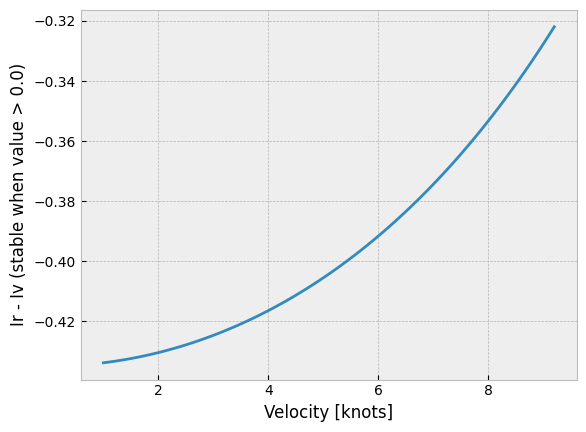

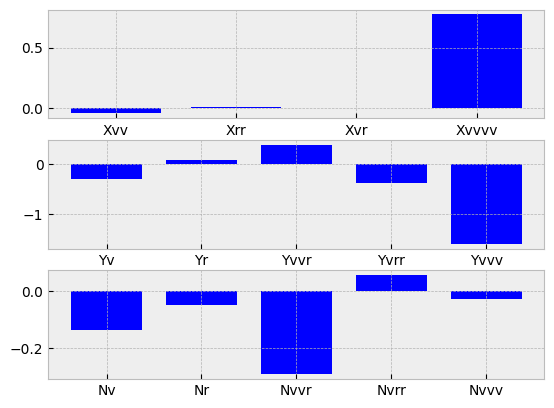

In [7]:
maneuvering_model = maneuvering.MMGModel(ship_dim, physical_constants)

#Check directional stability
U_man = np.linspace(1, max_speed_knots, n) * vessel_model_common.knots_to_ms

stability = np.zeros(n)
for i in range(n):
    stability[i] = maneuvering_model.check_linear_stability(U_man[i])
    
plt.figure()
plt.plot(U_man *vessel_model_common.ms_to_knots, stability)
plt.xlabel('Velocity [knots]')
plt.ylabel('Ir - Iv (stable when value > 0.0)')

#Visualize model parameters
maneuvering_model.plot_model_parameters()

# Seakeeping model

Heave: Natural period:  2.06s, damping ratio: 0.3
Roll: Natural period:  11.56s, damping ratio: 0.15
Pitch: Natural period:  3.86s, damping ratio: 0.3


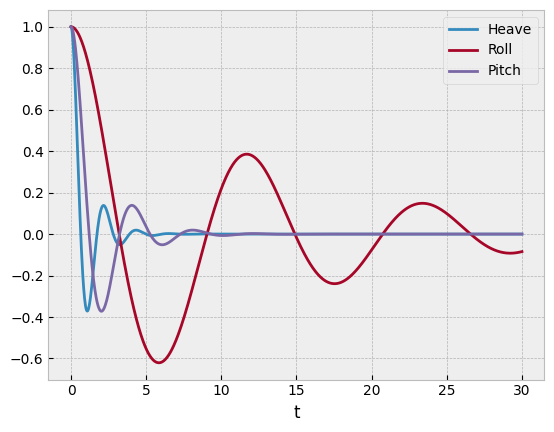

In [8]:
inertias = seakeeping.Inertias(ship_dim, physical_constants)#Set default values for inertias
inertias.set_horizontal_added_mass_from_maneuvering_model(maneuvering_model.added_mass)#Use values from maneuvering model in the horizontal dof's since these are avaiable

waterplane_area = ship_dim.C_water_plane*ship_dim.L*ship_dim.B
hydrostatics = seakeeping.Hydrostatics(GM_roll, GM_pitch, waterplane_area)

damping_ratios = [damping_ratio_heave, damping_ratio_roll, damping_ratio_pitch]

seakeeping_model = seakeeping.Seakeeping(ship_dim, physical_constants, hydrostatics, inertias, damping_ratios)

seakeeping_model.print_seakeeping_data()
seakeeping_model.plot_decay_response()



## Generate XML formatted FMU parameters that can be directly inserted into an OSP config

In [9]:
osp_param_gen = vessel_model_common.OSPParameterGen(ship_dim, physical_constants, maneuvering_model, seakeeping_model, resistance_model, prop)

#hull_maneuvering parameters
hull_maneuvering_params = osp_param_gen.generate_hull_maneuvering_params()
osp_param_gen.write_to_xml(hull_maneuvering_params, ship_name + '_hull_maneuvering_params.xml')
print("hull_maneuvering parameters:")
osp_param_gen.print_params(hull_maneuvering_params)
print("----------------------------------------------------")

#hull_seakeeping parameters
hull_seakeeping_params = osp_param_gen.generate_hull_seakeeping_params()
osp_param_gen.write_to_xml(hull_seakeeping_params, ship_name + '_hull_seakeeping_params.xml')
print("hull_seakeeping parameters:")
osp_param_gen.print_params(hull_seakeeping_params)
print("----------------------------------------------------")

#rigid_body parameters (Simulink version)
rigid_body_params = osp_param_gen.generate_rigid_body_params()
osp_param_gen.write_to_xml(rigid_body_params, ship_name + '_rigid_body_params.xml')
print("rigid_body parameters:")
osp_param_gen.print_params(rigid_body_params)
print("----------------------------------------------------")

#TODO: Add generation of thruster parameters

hull_maneuvering parameters:
Xvv	 -0.04
Xvr	 0.002
Xrr	 0.011
Xvvvv	 0.771
Yv	 -0.315
Yr	 0.083
Yvvv	 -1.607
Yvrr	 -0.391
Yvvr	 0.379
Yrrr	 0.008
Nv	 -0.137
Nr	 -0.049
Nvvv	 -0.03
Nvrr	 0.055
Nvvr	 -0.294
Nrrr	 -0.013
shape_factor	 0.025575
CR_m	 3.777153
CR_p	 4.930228
CD_lateral	 0.045
length	 54
depth	 0.8
wetted_surface	 438.540936
----------------------------------------------------
hull_seakeeping parameters:
mass	 250000.0
waterplane_area	 473.85
GM_roll	 10.0
GM_pitch	 80.0
heave_damping	 915640.638384
roll_damping	 13533242.689444
pitch_damping	 72293214.702349
----------------------------------------------------
rigid_body parameters:
m	 250000.0
m_added[1]	 25660.8
m_added[2]	 260107.2
m_added[3]	 251000.0
I[1]	 4192256.25
I[2]	 45562500.0
I[3]	 45562500.0
I_added[1]	 342225.0
I_added[2]	 28431000.0
I_added[3]	 37413446.4
----------------------------------------------------
